In [609]:
import pandas

import pygsheets
import numpy
import scipy
import re

import matplotlib
import matplotlib.pyplot as mp
import matplotlib.cm
import matplotlib.patheffects # for adding borders around text

import textwrap
import seaborn
import squarify

#import ttf_opensans

In [28]:
# set open sans as default font
mp.rcParams['font.family'] = 'Open Sans'

# gemplot variables

In [29]:
footer_color = "#222222"
footer_lineheight = 1.2
footer_fontsize = 14

# default height of a figure is 450 pixels

# gemstyle does this:
# specify a base_ratio, then set base_size = base_ratio*16
# 1. add 6 line margin all the way around
# 2. color of title is "#222222", margin 6666, size=base_size*1.5, lineheight=1.35, bold font
# 3. color of subtitle is "#333333", margin 0666, padding top=12, bottom=12, size=base_size*1.15, lineheight=1.45
# 4. set caption info as linehight=1.2, size=base_size*0.875, color="#222222", margin=18,6,6,6

base_ratio = 1.0
base_size = base_ratio * 16
color_title = "#222222"
color_subtitle = "#333333"
color_grid = "#cbcbcb"

text_weight_normal = 400
text_weight_bold = 700

# save fig
#' @keywords save_gem_plot
#' @examples
#' save_gem_plot(
#' plot_grid = line_plot_with_gem_footer,
#' save_filepath = "filename_that_my_plot_should_be_saved_to-nc.png",
#' width_pixels = 770,
#' height_pixels = 540,
#' resolution = 4
#' )
#'
#' @export
# save plot function - now separated from finalise_plot function and setting the resolution as part of the arguments
# save_gem_plot <- function (plot_grid, save_filepath, width_pixels = 640, height_pixels = 450, resolution = 3) {
#   grid::grid.draw(plot_grid)

#   #save it
#   ggplot2::ggsave(plot=plot_grid,
#                   width= (width_pixels/72),
#                   height= (height_pixels/72),
#                   dpi = resolution * 100,
#                   filename = save_filepath,
#                   bg="white")
# }

#width_pixels = 640 # default
#height_pixels = 450 # default

## define colors used in bars

In [30]:
sel_cmap = matplotlib.cm.get_cmap('Reds')
tracker_operating = sel_cmap(0.999)
tracker_construction = sel_cmap(0.8)
tracker_proposed = sel_cmap(0.6)
tracker_shelved = sel_cmap(0.4)
tracker_cancelled = sel_cmap(0.2)

/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_35322/1445812906.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  sel_cmap = matplotlib.cm.get_cmap('Reds')


# import data directly from google sheets

In [31]:
gc = pygsheets.authorize(service_account_env_var='GDRIVE_API_CREDENTIALS')
spreadsheet = gc.open_by_key('1foPLE6K-uqFlaYgLPAUxzeXfDO5wOOqE7tibNHeqTek')

gas_pipes = spreadsheet.worksheet('title','Gas pipelines').get_as_df(start='A2')
oil_pipes = spreadsheet.worksheet('title', 'Oil/NGL pipelines').get_as_df(start='A2')

pipes_df_orig = pandas.concat([gas_pipes, oil_pipes], ignore_index=True)

#get country ratios sheet
country_ratios_df = spreadsheet.worksheet('title', 'Country ratios by pipeline').get_as_df()
region_df_orig = spreadsheet.worksheet('title', 'Country dictionary').get_as_df(start='A2')

In [32]:
owners_df_orig = spreadsheet.worksheet('title', 'Pipeline operators/owners (1/3)').get_as_df(start='A2')
owners_df_orig = owners_df_orig.loc[owners_df_orig.ProjectID!='']
owners_df_orig = owners_df_orig.loc[owners_df_orig.Wiki!='']
owners_df = owners_df_orig.replace('',numpy.nan)

owner_parent_links_df = spreadsheet.worksheet('title', 'Owner–parent relationships (2/3)').get_as_df(start='A2')
# only keep the owners with a checked relationship
owner_parent_links_df = owner_parent_links_df.loc[owner_parent_links_df['Parent–Owner Relationship Checked?']=='yes']
owner_parent_links_df.replace('',numpy.nan,inplace=True)

parents_df = spreadsheet.worksheet('title', 'Parent metadata (3/3)').get_as_df(start='A2')
parents_df = parents_df.loc[parents_df.Parent!='']

owners_df.set_index('ProjectID', inplace=True)
owner_parent_links_df.set_index('Owner', inplace=True)
parents_df.set_index('Parent', inplace=True)

# ****************************************

## create list of owner and parent column names
owner_pct_col_names = []
owner_col_names = []

parent_pct_col_names = []
parent_col_names = []

for num in range(1,11+1):
    owner_pct_col = f'Owner{num}%'
    owner_pct_col_names.append(owner_pct_col)
    
    owner_col = f'Owner{num}'
    owner_col_names.append(owner_col)
    
    parent_pct_col = f'Parent{num}%'
    parent_pct_col_names.append(parent_pct_col)
    
    parent_col = f'Parent{num}'
    parent_col_names.append(parent_col)

# ****************************************
## fill in missing parent info by borrowing owner info
owners_FULL_set = owners_df[owner_col_names].stack().dropna().unique().tolist() # from owners_df
owners_researched_set = list(set(owner_parent_links_df.index.to_list()))#+['Unknown'] # only existing owners, plus 'Unknown'
owners_diff = list(set(owners_FULL_set)-set(owners_researched_set))
owners_diff.append('Unknown')

# update owner_parent_links_df with these extra owners
owner_parent_links_df = pandas.concat([owner_parent_links_df, pandas.DataFrame(index=owners_diff, columns=owner_parent_links_df.columns)])
owner_parent_links_df['Parent1'].loc[owners_diff] = owners_diff
owner_parent_links_df['Parent1%'].loc[owners_diff] = '100.00%'

# ****************************************
# update parents_df with these as well
# note countries will be unknkown...
parents_set = list(set(parents_df.index.to_list()))
parents_diff = list(set(owners_diff)-set(parents_set))
parents_diff.append('Unknown')
parents_df = pandas.concat([parents_df, pandas.DataFrame(numpy.nan, index=parents_diff, columns=parents_df.columns)])
parents_df.loc[parents_diff,'ParentHQCountry'] = 'Unknown'

In [33]:
status_list = ['Proposed', 
               'Construction', 
               'Shelved', 
               'Cancelled', 
               'Operating', 
               'Idle', 
               'Mothballed', 
               'Retired']
country_list = sorted(set(region_df_orig['Country'].tolist()))
region_list = sorted(set(region_df_orig['Region'].tolist()))
if '--' in region_list:
    region_list.remove('--')
subregion_list = sorted(set(region_df_orig['SubRegion'].tolist()))
if '--' in subregion_list:
    subregion_list.remove('--')

#country_list = sorted(list(set(terms_df_orig['Country'])))
#region_list = sorted(list(set(terms_df_orig['Region'])))

## replace "--" with NaN, removing empty rows

the dataset is structured to have -- wherever there's a lookup value that doesn't exist; replacing it with NaN (numpy.nan) allows pandas to treat it as a null value, which makes calculations much easier

In [34]:
# replace -- entries with NaN
pipes_df_orig = pipes_df_orig.replace('--', numpy.nan)
pipes_df_orig = pipes_df_orig[pipes_df_orig['PipelineName']!='']

missing_wiki_projectids = pipes_df_orig.loc[pipes_df_orig.Wiki==''].ProjectID.tolist()
pipes_df_orig = pipes_df_orig[pipes_df_orig['Wiki']!='']

country_ratios_df.replace('--', numpy.nan, inplace=True)
country_ratios_df = country_ratios_df.loc[~country_ratios_df.ProjectID.isin(missing_wiki_projectids)]

# km by country, km by region calculations

In [35]:
region_list

['Africa', 'Americas', 'Asia', 'Europe', 'Oceania']

In [36]:
subregion_list

['Australia and New Zealand',
 'Central Asia',
 'Eastern Asia',
 'Eastern Europe',
 'Latin America and the Caribbean',
 'Melanesia',
 'Micronesia',
 'Northern Africa',
 'Northern America',
 'Northern Europe',
 'Polynesia',
 'South-eastern Asia',
 'Southern Asia',
 'Southern Europe',
 'Sub-Saharan Africa',
 'Western Asia',
 'Western Europe']

In [37]:
dict_subregion_region = pandas.Series(region_df_orig.Region.values, index=region_df_orig.SubRegion).to_dict()
dict_subregion_region

{'Sub-Saharan Africa': 'Africa',
 'Northern Africa': 'Africa',
 'Latin America and the Caribbean': 'Americas',
 'Northern America': 'Americas',
 'Southern Asia': 'Asia',
 'Western Asia': 'Asia',
 'South-eastern Asia': 'Asia',
 'Eastern Asia': 'Asia',
 'Central Asia': 'Asia',
 'Northern Europe': 'Europe',
 'Southern Europe': 'Europe',
 'Western Europe': 'Europe',
 'Eastern Europe': 'Europe',
 'Polynesia': 'Oceania',
 'Australia and New Zealand': 'Oceania',
 'Melanesia': 'Oceania',
 'Micronesia': 'Oceania',
 '--': '--'}

In [38]:
region_df_orig_cleaned = region_df_orig.loc[(region_df_orig.Region!='--')&
                                            (region_df_orig.SubRegion!='--')]
multiindex_region_subregion = region_df_orig_cleaned.groupby(['Region','SubRegion'])['Country'].count().index
multiindex_region_subregion_country = region_df_orig_cleaned.groupby(['Region','SubRegion','Country'])['Country'].count().index

In [39]:
country_ratios_fuel_df = country_ratios_df[country_ratios_df['Fuel']=='Gas']

km_by_country_df = pandas.DataFrame(columns=status_list, index=country_list)
km_by_subregion_df = pandas.DataFrame(columns=status_list, index=multiindex_region_subregion)
km_by_region_df = pandas.DataFrame(columns=status_list, index=region_list)

print('===country-level calculations===')
for status in status_list:
    print(status)
    country_ratios_fuel_df_status = country_ratios_fuel_df[country_ratios_fuel_df['Status']==status]
    km_by_country_df[status] = country_ratios_fuel_df_status.groupby('Country')['MergedKmByCountry'].sum()
    km_by_subregion_df[status] = country_ratios_fuel_df_status.groupby(['Region','SubRegion'])['MergedKmByCountry'].sum()
    km_by_region_df[status] = country_ratios_fuel_df_status.groupby('Region')['MergedKmByCountry'].sum()

# # fill NaN with 0.0
km_by_subregion_df = km_by_subregion_df.fillna(0)
km_by_country_df = km_by_country_df.fillna(0)
km_by_region_df = km_by_region_df.fillna(0)

#km_by_region_df.sort_index(level='Region', inplace=True)
#km_by_region_df = km_by_region_df.loc[~(km_by_region_df==0).all(axis=1)]

# total
# km_by_region_df.loc['Total',:] = km_by_region_df.sum(axis=0).values
# km_by_country_df.loc['Total',:] = km_by_country_df.sum(axis=0).values

km_by_subregion_df['Proposed+Construction'] = km_by_subregion_df[['Proposed','Construction']].sum(axis=1)
km_by_subregion_df = km_by_subregion_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]

km_by_country_df['Proposed+Construction'] = km_by_country_df[['Proposed','Construction']].sum(axis=1)
km_by_country_df.sort_values('Proposed+Construction', ascending=False, inplace=True)
km_by_country_df = km_by_country_df.loc[~(km_by_country_df==0).all(axis=1)]
km_by_country_df.loc[:,'Region'] = region_df_orig.set_index('Country').loc[km_by_country_df.index.tolist()].Region
km_by_country_df.loc[:,'Subregion'] = region_df_orig.set_index('Country').loc[km_by_country_df.index.tolist()].SubRegion
km_by_country_df = km_by_country_df[['Region','Subregion','Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
km_by_country_df = km_by_country_df.loc[(km_by_country_df.Region!='--')&
                                        (km_by_country_df.Subregion!='--')]

km_by_region_df['Proposed+Construction'] = km_by_region_df[['Proposed','Construction']].sum(axis=1)
km_by_region_df = km_by_region_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]

km_by_subregion_df.index.set_names(['Region','Subregion'], inplace=True)
km_by_subregion_df.loc['Total',:] = km_by_subregion_df.sum(axis=0).values
km_by_subregion_df.replace(0,'', inplace=False)

===country-level calculations===
Proposed
Construction
Shelved
Cancelled
Operating
Idle
Mothballed
Retired


Proposed Construction  \
Region   Subregion                                                 
Africa   Northern Africa                     4072.7       187.93   
         Sub-Saharan Africa                 18561.8       1582.0   
Americas Latin America and the Caribbean   17090.97       2170.0   
         Northern America                   8571.63      2515.84   
Asia     Central Asia                       3867.22      1604.33   
         Eastern Asia                      37446.81     30365.16   
         South-eastern Asia                 8849.03       1087.3   
         Southern Asia                     12731.61     22425.64   
         Western Asia                       6015.84      2153.52   
Europe   Eastern Europe                    21303.58      3830.21   
         Northern Europe                    1111.49          1.2   
         Southern Europe                    8526.75      1656.29   
         Western Europe                       708.3         82.0   
Oceania  Australia and New Zealand          9856.64          4.3   
         Melanesia                            320.0                
         Micronesia                                                
         Polynesia                                                 
Total                                     159034.37     69665.72   

                                         Proposed+Construction   Shelved  \
Region   Subregion                                                         
Africa   Northern Africa                               4260.63    172.21   
         Sub-Saharan Africa                            20143.8   1319.72   
Americas Latin America and the Caribbean              19260.97   3097.05   
         Northern America                             11087.47   3456.39   
Asia     Central Asia                                  5471.55             
         Eastern Asia                                 67811.97   1784.07   
         South-eastern Asia                            9936.33   2712.41   
         Southern Asia                                35157.25    1752.0   
         Western Asia                                  8169.36   1845.76   
Europe   Eastern Europe                               25133.79   4553.92   
         Northern Europe                               1112.69    1000.0   
         Southern Europe                              10183.04    764.54   
         Western Europe                                  790.3     69.25   
Oceania  Australia and New Zealand                     9860.94   3726.22   
         Melanesia                                       320.0     400.0   
         Micronesia                                                        
         Polynesia                                                         
Total                                                228700.09  26653.54   

                                         Cancelled   Operating     Idle  \
Region   Subregion                                                        
Africa   Northern Africa                     589.0     24859.7            
         Sub-Saharan Africa                 228.96     7141.52            
Americas Latin America and the Caribbean   2344.66    59836.28    331.0   
         Northern America                 20654.81   401851.87     50.0   
Asia     Central Asia                      2590.59    29099.49            
         Eastern Asia                      2827.38   127567.05            
         South-eastern Asia                 1329.0    17665.11            
         Southern Asia                    10509.97     39861.3            
         Western Asia                      9827.63    36466.83            
Europe   Eastern Europe                    8475.95   141231.72  1651.65   
         Northern Europe                   1003.77    25588.17            
         Southern Europe                   4436.09    27759.83            
         Western Europe                     2138.2    28610.48     8.35   
Oceania  Australia and New Zealand  

In [40]:
km_by_country_df.to_excel('km-by-country-region-subregion.xlsx')
km_by_country_df

,Region,Subregion,Proposed,Construction,Proposed+Construction,Shelved,Cancelled,Operating,Idle,Mothballed,Retired
China,Asia,Eastern Asia,36090.21,30313.36,66403.57,731.11,1462.87,122333.77,0.00,0.0,114.40
Russia,Europe,Eastern Europe,18444.52,2901.93,21346.45,1246.65,4904.56,113072.59,414.27,1177.3,2000.58
India,Asia,Southern Asia,5573.68,15283.00,20856.68,1055.00,4671.05,19019.42,0.00,0.0,0.00
Australia,Oceania,Australia and New Zealand,9856.64,4.30,9860.94,3726.22,7214.68,29524.31,0.00,0.0,0.00
United States,Americas,Northern America,7237.22,1448.00,8685.22,3374.58,14090.54,340248.82,50.00,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...
Libya,Africa,Northern Africa,0.00,0.00,0.00,0.00,115.56,6243.07,0.00,0.0,0.00
Liechtenstein,Europe,Western Europe,0.00,0.00,0.00,0.00,1.90,1.29,0.00,0.0,0.00
Luxembourg,Europe,Western Europe,0.00,0.00,0.00,0.00,0.00,150.95,0.00,0.0,0.00
Macao,Asia,Eastern Asia,0.00,0.00,0.00,0.00,0.00,12.80,0.00,0.0,0.00


In [41]:
km_by_country_df.sort_values('Construction', ascending=False).to_excel('km-by-country-region-subregion-sorted-by-construction.xlsx')
#km_by_country_df

In [42]:
km_by_region_df

,Proposed,Construction,Proposed+Construction,Shelved,Cancelled,Operating,Idle,Mothballed,Retired
Africa,22634.50,1769.93,24404.43,1491.93,817.96,32001.22,0.0,1107.39,0.00
Americas,25662.60,4685.84,30348.44,6553.44,22999.47,461688.15,381.0,224.00,0.00
Asia,68910.51,57635.95,126546.46,8094.24,27084.57,250659.78,0.0,1373.59,229.68
Europe,31650.12,5569.70,37219.82,6387.71,16054.01,223190.20,1660.0,5225.10,3182.27
Oceania,10176.64,4.30,10180.94,4126.22,7515.50,32754.31,0.0,0.00,0.00


## figure for km by subregion (marimekko/mosaic type)

In [61]:
treemap_colors = {'Americas':'#c75a00',
                  'Asia':'#580000',
                  'Europe':'#902c00',
                  'Africa':'#f98c28',
                  'Oceania':'#ffd370'}

In [64]:
regional_sum_df_normalized

,Proposed,Construction,Proposed+Construction,Shelved,Cancelled,Operating,Idle,Mothballed,Retired
Region,,,,,,,,,
Asia,0.433306,0.827322,0.553329,0.303683,0.363690,0.250586,0.000000,0.173213,0.067316
Europe,0.199014,0.079949,0.162745,0.239657,0.215573,0.223125,0.813327,0.658896,0.932684
Americas,0.161365,0.067262,0.132700,0.245875,0.308836,0.461553,0.186673,0.028247,0.000000
Africa,0.142325,0.025406,0.106709,0.055975,0.010984,0.031992,0.000000,0.139644,0.000000
Oceania,0.063990,0.000062,0.044517,0.154809,0.100918,0.032745,0.000000,0.000000,0.000000


In [466]:
# build bar thicknesses, normalized by total and by regional subtotals
km_by_subregion_df_toplot = km_by_subregion_df.drop('Total')

regional_sum_df = km_by_subregion_df_toplot.groupby(level='Region').sum()
region_order = regional_sum_df.sort_values(by='Proposed+Construction', ascending=False).index.values
regional_sum_df = regional_sum_df.reindex(index=region_order)

# sort first by proposed+construction values, THEN reorder based on region_order
km_by_subregion_df_toplot = km_by_subregion_df_toplot.sort_values(
    ['Region','Proposed+Construction'], ascending=False).reindex(
    level=0, index=region_order)

# before normalizing stuff, get km thickness
bar_thickness_km_df = km_by_subregion_df_toplot[['Proposed+Construction']]
regional_sum_df_normalized = regional_sum_df/regional_sum_df.sum(axis=0)

# normalize km_by_subregion so that each region adds up to 1.0
km_by_subregion_df_toplot_normalized = km_by_subregion_df_toplot/regional_sum_df
# then multiply by region_sum_df_normalized so ALL regions add up to a total of 1.0
# this will be what you need to plot for a normalized y-axis marimekko
km_by_subregion_df_toplot_normalized = (km_by_subregion_df_toplot_normalized*regional_sum_df_normalized).replace(numpy.nan,0)

bar_thickness_df = km_by_subregion_df_toplot_normalized[['Proposed+Construction']]
# we only care about what's under construction or proposed, so normalize the first two columns by Proposed+Construction
bar_fractional_width_df = km_by_subregion_df_toplot_normalized[['Proposed','Construction']].div(
    km_by_subregion_df_toplot_normalized[['Proposed','Construction']].sum(axis=1), axis=0).replace(numpy.nan,0) 

# # remove all-zero rows
bar_thickness_df = bar_thickness_df.loc[(bar_thickness_df!=0).any(axis=1)]
bar_thickness_km_df = bar_thickness_km_df.loc[(bar_thickness_km_df!=0).any(axis=1)]
bar_fractional_width_df = bar_fractional_width_df.loc[(bar_fractional_width_df!=0).any(axis=1)]
bar_percentage_width_df = bar_fractional_width_df*100.

# add a colors column to bar_thickness_df
bar_thickness_df['Colors'] = ''
bar_thickness_km_df['Colors'] = ''
for idx,row in bar_thickness_df.iterrows():
    bar_thickness_df.loc[idx,'Colors'] = treemap_colors[idx[0]]
    bar_thickness_km_df.loc[idx,'Colors'] = treemap_colors[idx[0]]

km_by_subregion_df_toplot['Colors'] = ''
for idx,row in km_by_subregion_df_toplot.iterrows():
    km_by_subregion_df_toplot.loc[idx,'Colors'] = treemap_colors[idx[0]]

In [467]:
km_by_region_df

,Proposed,Construction,Proposed+Construction,Shelved,Cancelled,Operating,Idle,Mothballed,Retired
Africa,22634.50,1769.93,24404.43,1491.93,817.96,32001.22,0.0,1107.39,0.00
Americas,25662.60,4685.84,30348.44,6553.44,22999.47,461688.15,381.0,224.00,0.00
Asia,68910.51,57635.95,126546.46,8094.24,27084.57,250659.78,0.0,1373.59,229.68
Europe,31650.12,5569.70,37219.82,6387.71,16054.01,223190.20,1660.0,5225.10,3182.27
Oceania,10176.64,4.30,10180.94,4126.22,7515.50,32754.31,0.0,0.00,0.00


## figure 1 - marimekko

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(-0.17216589861751153, -0.1323529411764706, 'Source: Global Gas Infrastructure Tracker\nDarker colors show pipelines under construction;\nlighter colors show proposed pipelines')

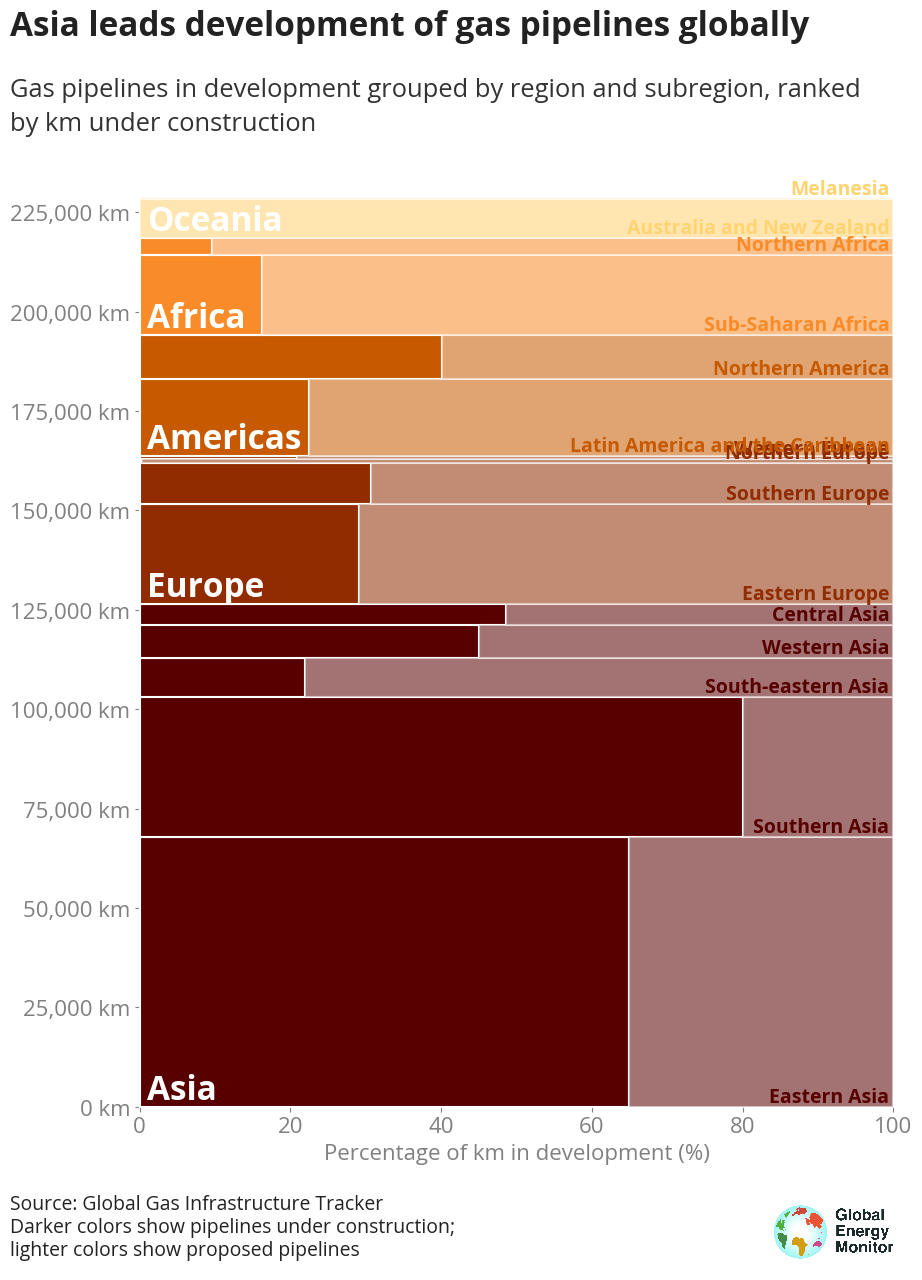

In [468]:
width_pixels = 700 # 640 default
height_pixels = 850 # 450 default
fig = mp.figure(figsize=(width_pixels/72, height_pixels/72))
fig.canvas.draw()
axis_text_color = '0.5'

nbars = bar_thickness_df.shape[0]
bar_km_cumsum = bar_thickness_km_df['Proposed+Construction'].cumsum().values
bar_lower_edges = numpy.append(numpy.array(0), bar_km_cumsum[:-1])
bar_center_points = (numpy.append(numpy.array(0), bar_km_cumsum)[1:] - numpy.append(numpy.array(0), bar_km_cumsum)[:-1])/2 +\
    numpy.append(numpy.array(0), bar_km_cumsum[:-1])

region_km_cumsum = regional_sum_df['Proposed+Construction'].cumsum().values
region_lower_edges = numpy.append(numpy.array(0), region_km_cumsum[:-1])
region_center_points = (numpy.append(numpy.array(0), region_km_cumsum)[1:] - numpy.append(numpy.array(0), region_km_cumsum)[:-1])/2 +\
    numpy.append(numpy.array(0), region_km_cumsum[:-1])

ax = fig.add_subplot(111)

ax.barh(y=bar_lower_edges,
        align='edge',
        width=bar_percentage_width_df.Construction,
        height=bar_thickness_km_df['Proposed+Construction'].values,
        edgecolor='1',
        linewidth=1.5,
        color=bar_thickness_km_df['Colors'].tolist(),
        left=0,
        clip_on=False)

ax.barh(y=bar_lower_edges,
        align='edge',
        width=bar_percentage_width_df.Proposed,
        height=bar_thickness_km_df['Proposed+Construction'].values,
        edgecolor='1',
        linewidth=1.5,
        color=bar_thickness_km_df['Colors'].tolist(),
        alpha=0.55,
        left=bar_percentage_width_df.Construction,
        clip_on=False)

for i in range(nbars):
    ax.text(s=bar_thickness_km_df.index.get_level_values('Subregion').tolist()[i],
            x=99.5,
            y=bar_lower_edges[i]+0.01,
            ha='right',
            va='bottom',
            color=bar_thickness_km_df['Colors'].tolist()[i],
            size=base_size*0.875,
            weight=text_weight_bold)

for i in range(region_list.__len__()):
    ax.text(s=region_order[i],
            x=1,
            y=region_lower_edges[i]+0.005,#region_center_points[i],
            ha='left',
            va='bottom',
            size=base_size*1.5,
            color='1',
            weight=text_weight_bold)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.tick_params(labelsize=base_size,
               color=axis_text_color,
               labelcolor=axis_text_color,)

# format axis to have proper units and commas in thousands place
ax.yaxis.set_ticks(numpy.arange(0,ax.get_ylim()[1],25000))
ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f} km'))
ax.set_ylim(0,bar_thickness_km_df.sum().values[0])
ax.set_xlim(0,100.)
#ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2)) # 2 for dividing major ticks into 2

ax.set_axisbelow(True)

# add titles, first get the location of the yaxis labels so they can line up exactly
# call it "x_location"
bbox = ax.get_tightbbox() #ax.get_yticklabels()[-1].get_window_extent()
x_location,y_location = ax.transAxes.inverted().transform([bbox.x0, bbox.y1])
ax.text(s='Gas pipelines in development grouped by region and subregion, ranked\nby km under construction',
        size=base_size*1.15,
        color=color_subtitle,
        x=x_location,
        y=1.1,
        ha='left',
        va='center',
        weight=text_weight_normal,
        transform=ax.transAxes,
        linespacing=1.45,
        wrap=True)

bbox_with_subtitle = ax.get_tightbbox()
x_location_subtitle,y_location_subtitle = ax.transAxes.inverted().transform([bbox_with_subtitle.x0, bbox_with_subtitle.y1])
ax.text(s='Asia leads development of gas pipelines globally',
        size=base_size*1.5,
        color=color_title,
        x=x_location,
        y=y_location_subtitle*1.05,#1.2,
        ha='left',
        va='center',
        weight=text_weight_bold,
        transform=ax.transAxes,
        linespacing=1.35,
        wrap=False)

ax.set_xlabel('Percentage of km in development (%)',
              size=base_size, color=axis_text_color)

# LEGEND AND GEM LOGO
ax.legend(fontsize=base_size,
          frameon=False,
          loc='lower left',
          bbox_to_anchor=(x_location,1.025),
          bbox_transform=ax.transAxes,
          handlelength=1,
          handleheight=1,
          ncols=4,
          borderpad=0,
          borderaxespad=0,
          columnspacing=0.75,
          handletextpad=0.25)

gem_logo = matplotlib.image.imread('/Users/baird/Dropbox/_git_ALL/_github-repos-gem/gemplot-python/data/gem_logo_padding.png')
logo_image_box = matplotlib.offsetbox.OffsetImage(gem_logo, zoom=0.035)
logo_annotation_box = matplotlib.offsetbox.AnnotationBbox(logo_image_box,
                                                          (1,0), # sets box alignment to lower right corder
                                                          xycoords='axes fraction',
                                                          box_alignment=(1.,2.5), 
                                                          frameon=False)
ax.add_artist(logo_annotation_box)

# note at bottom
ax.text(s='Source: Global Gas Infrastructure Tracker\nDarker colors show pipelines under construction;\nlighter colors show proposed pipelines',
        size=base_size*0.875,
        color=color_title,
        x=x_location,
        y=-0.25*450/height_pixels,
        ha='left',
        va='center',
        weight=text_weight_normal,
        transform=ax.transAxes,
        linespacing=1.2,
        wrap=False)

# ax.tick_params(labelsize=font_size)
# ax.set_ylabel('km of pipelines in development', size=font_size)
# ax.set_xlabel('Fraction of pipelines under construction (left)\nand proposed (right)', size=font_size)

## figure 1 - tree map alternative

In [610]:
subregion_values_df

,Subregion,Construction
Region,,
Asia,Eastern Asia,30365.16
Asia,Southern Asia,22425.64
Asia,South-eastern Asia,1087.30
Asia,Western Asia,2153.52
Asia,Central Asia,1604.33


In [647]:
km_by_region_df

,Proposed,Construction,Proposed+Construction,Shelved,Cancelled,Operating,Idle,Mothballed,Retired
Africa,22634.50,1769.93,24404.43,1491.93,817.96,32001.22,0.0,1107.39,0.00
Americas,25662.60,4685.84,30348.44,6553.44,22999.47,461688.15,381.0,224.00,0.00
Asia,68910.51,57635.95,126546.46,8094.24,27084.57,250659.78,0.0,1373.59,229.68
Europe,31650.12,5569.70,37219.82,6387.71,16054.01,223190.20,1660.0,5225.10,3182.27
Oceania,10176.64,4.30,10180.94,4126.22,7515.50,32754.31,0.0,0.00,0.00


In [654]:
'{x:,.0f} km'.format(x=round(km_by_region_df.loc['Asia',which_status],-2))

'57,600 km'

In [660]:
normalized_region_values

[8273.215291537934,
 799.4893327737086,
 672.6177523177828,
 254.06039010290863,
 0.6172332676673694]

In [678]:
numpy.log(normalized_region_values)

array([ 9.0207785 ,  6.68397319,  6.51117719,  5.537572  , -0.48250826])

Asia
Europe
Americas
Africa
Oceania


Text(0.0, -0.125, 'Source: Global Gas Infrastructure Tracker')

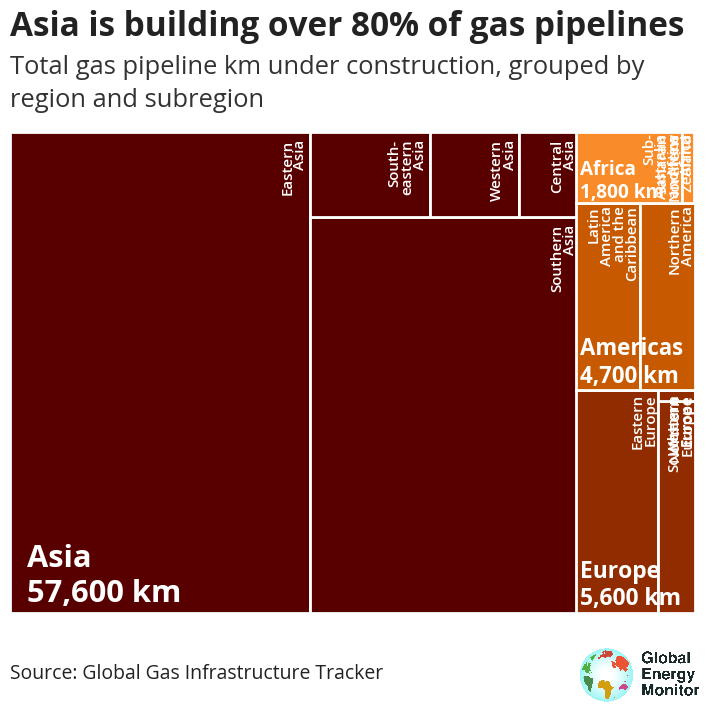

In [710]:
width_pixels = 640 # 640 default
height_pixels = 450 # 450 default
fig = mp.figure(figsize=(width_pixels/72, height_pixels/72))
fig.canvas.draw()
axis_text_color = '0.5'

ax=fig.add_subplot(111)
ax.axis('off')

which_status = 'Construction'
subregion_divider_lw = 2
region_divider_lw = 3
divider_lc = '1'

# first normalize region sizes (computes the areas for the treemap)
normalized_region_values = squarify.normalize_sizes(regional_sum_df[which_status].values,
                                                    dx=100,
                                                    dy=100)
# squarify them now (computes where they are arranged)
squarified_region_values = squarify.squarify(normalized_region_values,
                                             x=0,
                                             y=0,
                                             dx=100,
                                             dy=100)

km_by_subregion_df_treemap = km_by_subregion_df_toplot[[which_status]].reset_index(level=1)
# remove all zero rows
#km_by_subregion_df_treemap = km_by_subregion_df_treemap.loc[km_by_subregion_df_treemap[which_status]!=0]

ax_bbox = ax.get_position() # gives x0, y0, xwidth, yheight
x_scale = ax_bbox.bounds[2]
y_scale = ax_bbox.bounds[3]

#for i in [0]:#range(len(squarified_region_values)):
for i in range(len(squarified_region_values)):
    
    region_name = regional_sum_df.index.tolist()[i]
    print(region_name)

    # create region dividers
    ax_new = fig.add_axes([squarified_region_values[i]['x']/100*y_scale+ax_bbox.bounds[0],
                           squarified_region_values[i]['y']/100*y_scale+ax_bbox.bounds[1],
                           squarified_region_values[i]['dx']/100*x_scale,
                           squarified_region_values[i]['dy']/100*y_scale],
                          frameon=True,
                          transform=ax.transAxes)

    # pull out subregion values
    subregion_values_df = km_by_subregion_df_treemap.loc[region_name]
    # drop anything equal to zero
    subregion_values_df = subregion_values_df.loc[subregion_values_df[which_status]!=0]
    subregion_values = subregion_values_df.sort_values(which_status, ascending=False)[which_status].values
    
    normalized_subregion_values = squarify.normalize_sizes(subregion_values,
                                                           dx=squarified_region_values[i]['dx'],
                                                           dy=squarified_region_values[i]['dy'])

    # squarified_subregion_values = squarify.squarify(normalized_subregion_values,
    #                                                 x=0,
    #                                                 y=0,
    #                                                 #x=squarified_region_values[i]['x']/100*y_scale+ax_bbox.bounds[0],
    #                                                 #y=squarified_region_values[i]['y']/100*y_scale+ax_bbox.bounds[1],
    #                                                 dx=100,
    #                                                 dy=100)
    #                                                 #dx=,
    #                                                 #dy=)

    ax_new.axis('off')
    
    #subregion squarify plot
    squarify.plot(normalized_subregion_values,
                  norm_x=100,
                  norm_y=100,
                  ax=ax_new,
                  pad=False,
                  color=[treemap_colors[region_name]]*normalized_subregion_values.__len__(),
                  linewidth=subregion_divider_lw,
                  clip_on=False,
                  edgecolor=divider_lc)
    
    # first do left right top bottom (outline the region)
    # ax_new.axhline(y=0, xmin=0, xmax=1, 
    #                color=divider_lc,
    #                #clip_on=False,
    #                lw=region_divider_lw)
    # ax_new.axhline(y=100, xmin=0, xmax=1, 
    #                color=divider_lc, 
    #                #clip_on=False,
    #                lw=region_divider_lw)    
    # ax_new.axvline(x=0, ymin=0, ymax=1, 
    #                color=divider_lc,
    #                #clip_on=False,
    #                lw=region_divider_lw)
    # ax_new.axvline(x=100, ymin=0, ymax=1, 
    #                color=divider_lc,
    #                #clip_on=False,
    #                lw=region_divider_lw)

    # add labels for regions

    region_text = ax_new.text(s=region_name+'\n'+'{x:,.0f} km'.format(x=round(km_by_region_df.loc[region_name,which_status],-2)),
                x=0.03,
                y=0.01,
                transform=ax_new.transAxes,
                ha='left',
                va='bottom',
                #wrap=True,
                #size=base_size*squarified_region_values[i]['dx']/100*x_scale*6.5, # scaling text size by the dx value with a multiplier around 4.4
                size=base_size*numpy.log(normalized_region_values[i])/6.5,
                color='1',
                weight=text_weight_bold)

    # for each region plot with subregions, get the rectangles (bars) of the subregions
    # final entry of bars is the full box of the plot, I think, so use N-1 of them...
    bars = [rect for rect in ax_new.get_children() if isinstance(rect, matplotlib.patches.Rectangle)][:-1]
    for j in range(bars.__len__()):
        # get lower left, top right corner of boxes
        x0,y0,x1,y1 = bars[j].get_bbox().x0, bars[j].get_bbox().y0, bars[j].get_bbox().x1, bars[j].get_bbox().y1
        ax_new.text(x=x1-0.5,y=y1-1.5,
                    s='\n'.join(
                        textwrap.wrap(
                        subregion_values_df.Subregion.tolist()[j],
                        10,
                        break_long_words=False)
                    ),
                    size=base_size*0.675,
                    color='1',
                    rotation=90,
                    ha='right',
                    va='top',
                    weight=600,#text_weight_bold,
                    linespacing=0.9)


# add titles, first get the location of the yaxis labels so they can line up exactly
# call it "x_location"
bbox = ax.get_tightbbox() #ax.get_yticklabels()[-1].get_window_extent()
x_location,y_location = ax.transAxes.inverted().transform([bbox.x0, bbox.y1])
ax.text(s='Total gas pipeline km under construction, grouped by\nregion and subregion',
        size=base_size*1.15,
        color=color_subtitle,
        x=x_location,
        y=1.1,
        ha='left',
        va='center',
        weight=text_weight_normal,
        transform=ax.transAxes,
        linespacing=1.45,
        wrap=True)

bbox_with_subtitle = ax.get_tightbbox()
x_location_subtitle,y_location_subtitle = ax.transAxes.inverted().transform([bbox_with_subtitle.x0, bbox_with_subtitle.y1])
ax.text(s='Asia is building over 80% of gas pipelines',
        size=base_size*1.5,
        color=color_title,
        x=x_location,
        y=y_location_subtitle*1.05,#1.2,
        ha='left',
        va='center',
        weight=text_weight_bold,
        transform=ax.transAxes,
        linespacing=1.35,
        wrap=False)

ax.set_xlabel('Percentage of km in development (%)',
              size=base_size, color=axis_text_color)

# LEGEND AND GEM LOGO
gem_logo = matplotlib.image.imread('/Users/baird/Dropbox/_git_ALL/_github-repos-gem/gemplot-python/data/gem_logo_padding.png')
logo_image_box = matplotlib.offsetbox.OffsetImage(gem_logo, zoom=0.035)
logo_annotation_box = matplotlib.offsetbox.AnnotationBbox(logo_image_box,
                                                          (1,0), # sets box alignment to lower right corder
                                                          xycoords='axes fraction',
                                                          box_alignment=(1.,1.5), 
                                                          frameon=False)
ax.add_artist(logo_annotation_box)

# note at bottom
ax.text(s='Source: Global Gas Infrastructure Tracker',
        size=base_size*0.875,
        color=color_title,
        x=x_location,
        y=-0.125*450/height_pixels,
        ha='left',
        va='center',
        weight=text_weight_normal,
        transform=ax.transAxes,
        linespacing=1.2,
        wrap=False)

# projects by country, by region

In [ ]:
country_ratios_fuel_df = country_ratios_df[country_ratios_df['Fuel']=='Gas']

num_by_country_df = pandas.DataFrame(columns=status_list, index=country_list)
num_by_region_df = pandas.DataFrame(columns=status_list, index=region_list)

print('===country-level calculations===')
for status in status_list:
    print(status)
    country_ratios_fuel_df_status = country_ratios_fuel_df[country_ratios_fuel_df['Status']==status]
    num_by_country_df[status] = country_ratios_fuel_df_status.groupby('ProjectID')['MergedKmByCountry'].count()

print('===regional calculations===')
for status in status_list:
    print(status)
    country_ratios_fuel_df_status = country_ratios_fuel_df[country_ratios_fuel_df['Status']==status]
    num_by_region_df[status] = country_ratios_fuel_df_status.groupby('Region')['MergedKmByCountry'].count()

# # fill NaN with 0.0
num_by_region_df = num_by_region_df.fillna(0)
num_by_country_df = num_by_country_df.fillna(0)

In [ ]:
num_by_region_df

# numbers of pipes finished in a given year

In [ ]:
# count pipelines that are already operating
pipes_started = pipes_df_orig.copy()
pipes_started['StartYearEarliest'].replace(numpy.nan,'',inplace=True)
pipes_started = pipes_started[(pipes_started['Status'].isin(['Operating'])) &
                              (pipes_started['Fuel']=='Gas')]
pipes_started_sum = pipes_started.groupby('StartYearEarliest')['LengthMergedKm'].sum()

In [ ]:
# count km of pipeline for each start year
pipes_started_startyear = pipes_df_orig.copy()
pipes_started_startyear['StartYearEarliest'].replace(numpy.nan,'',inplace=True)
pipes_started_startyear = pipes_started_startyear[(pipes_started_startyear['Status'].isin(['Operating'])) &
                              (pipes_started_startyear['Fuel']=='Gas')]
#pipes_started_startyear_sum = pipes_started_startyear.groupby('StartYearLatest')['LengthMergedKm'].sum()

In [ ]:
# indev pipelines = Proposed or Construction or Shelved
pipes_indev = pipes_df_orig.copy()
pipes_indev = pipes_indev.loc[(pipes_indev.Fuel=='Gas')&
                              (pipes_indev.Status.isin(['Proposed','Construction','Shelved']))].groupby('Status')['LengthMergedKm'].sum()
#pipes_indev = pipes_indev.loc[(pipes_indev.StartYearEarliest>2022)|
#                              (pipes_indev.StartYearEarliest.isna())].groupby('Status')['LengthMergedKm'].sum()

In [ ]:
pipes_indev_to2030 = pipes_df_orig.copy()
pipes_indev_to2030 = pipes_indev_to2030.loc[(pipes_indev_to2030['Fuel']=='Gas') &
                                        (pipes_indev_to2030['Status'].isin(['Proposed','Construction','Shelved'])) &
                                        (pipes_indev_to2030['StartYearEarliest'].isin(list(range(2023,2031))))]
pipes_indev_to2030 = pipes_indev_to2030.groupby('Status')['LengthMergedKm'].sum()


In [ ]:
pipes_indev_startyear = pipes_df_orig.copy()
pipes_indev_startyear = pipes_indev_startyear[(pipes_indev_startyear['Status'].isin(['Proposed','Construction','Shelved'])) &
                                              (pipes_indev_startyear['Fuel']=='Gas')]
pipes_indev_startyear = pipes_indev_startyear.groupby(['Status','StartYearEarliest'], dropna=False)['LengthMergedKm'].sum(min_count=1)

In [ ]:
pipes_indev_startyear.unstack()

In [ ]:
pipes_indev_startyear['Construction',2023]

## 2023–2030 figure, go back to 2008

## future/past plot

In [ ]:
font_size = 7

ytop = 30000
ytop2 = 250000
xlo = 2008
xhi = 2023

fig = mp.figure(figsize=(3.25,4))

widths=[15,2.25]
spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=widths)

ax = fig.add_subplot(spec[0,0])

ax.bar(pipes_started_sum.loc[range(xlo,xhi+1)].index.values, pipes_started_sum.loc[range(xlo,xhi+1)].values,
       color=tracker_operating, label='Operating') # color=solar_base03

ax.bar(2023,pipes_indev_startyear['Construction',2023],
       label='Construction\n(scheduled\nfor 2023)', bottom=pipes_started_sum.loc[2023], 
       facecolor=tracker_operating, alpha=0.25)

ax.tick_params(labelsize=font_size)
ax.tick_params('x', rotation=45)
ax.set_ylabel('km', size=font_size)

ax.set_xlim(xlo-0.75, xhi+0.75)
ax.set_ylim(0, ytop)

ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

ax2 = fig.add_subplot(spec[0,1])
ax2.set_ylim(0, ytop2)
ax2.set_xlim(0.25,2.75)
xvals = [1.5]

colors = [tracker_construction, tracker_proposed]#, tracker_shelved]
status = ['Construction', 'Proposed']#, 'Shelved']
ax2_list = []


ax2_list.append(ax2.bar(xvals[0], pipes_indev['Construction'],
                 color=tracker_construction, label='Construction'))

ax2_list.append(ax2.bar(xvals[0], pipes_indev['Proposed']-pipes_indev_startyear['Construction',2023],
                        bottom=pipes_indev['Construction'],
                 color=tracker_shelved, label='Proposed'))

ax_h, ax_l = ax.get_legend_handles_labels()
ax2_h, ax2_l = ax2.get_legend_handles_labels()

ax2.set_xticklabels([])
ax2.tick_params(labelsize=font_size)
ax2.set_xticks([])

ax2.set_yticks([250000])
ax2.set_yticklabels(['250000'])
ax2.yaxis.tick_right()

ax.legend(handles=ax_h+ax2_h, fontsize=font_size, frameon=False, 
          loc='upper left', bbox_to_anchor=[0.05,1])

axpos = ax.get_position()
ax2pos = ax2.get_position()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.spines['bottom'].set_visible(False)

ax2.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['right'].set_visible(True)

ax.set_title('commissioned by year', fontsize=font_size)
ax2.set_title('future', fontsize=font_size)

fig.tight_layout(w_pad=0.5)

ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))
#ax2.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))

mp.savefig('../figures/gas-pipelines_km-by-start-year.png', bbox_inches='tight', transparent=True, dpi=600)
mp.savefig('../figures/gas-pipelines_km-by-start-year.pdf', bbox_inches='tight', transparent=True)

In [ ]:
pipes_indev

## percent pipelines with start date (sanity check)

In [ ]:
pipes_scratch = pipes_df_orig.copy()
pipes_scratch = pipes_scratch[(pipes_scratch['Fuel']=='Gas') &
                              (pipes_scratch['Status'].isin(['Proposed','Construction','Shelved']))]

In [ ]:
pipes_scratch[~pipes_scratch['StartYearEarliest'].isnull()]['StartYearEarliest'].count()/pipes_scratch.shape[0]


## regional pipelines started in given year

In [ ]:
pipes_df_orig['StartYearEarliest'].min()

In [ ]:
years_array = numpy.arange(float(pipes_df_orig['StartYearEarliest'].min()), 
                           float(pipes_df_orig['StartYearEarliest'].max())+1)
regions_startyear_sums_df = pandas.DataFrame(numpy.nan, index=years_array, columns=region_list)

In [ ]:
#pipes_started = pipes_df.copy()[(pipes_df['Status'].isin(['Operating'])) & pipes_df['Fuel']=='oil']
#pipes_started_sum = pipes_started.groupby('StartYearLatest')['LengthMergedKm'].sum()

for region in region_list:
    pipes_started = pipes_df_orig.copy()[(pipes_df_orig['Status'].isin(['Operating','Retired','Idle'])) & 
                                    (pipes_df_orig['Fuel']=='Gas')]
    pipes_started = pipes_started[pipes_started['StartRegion']==region]
    pipes_started_sum_up = pipes_started.groupby('StartYearEarliest')['LengthMergedKm'].sum()
    
    regions_startyear_sums_df[region] = pipes_started_sum_up

## plot pie chart of regional values

In [ ]:
# mess with some color pallettes
#seaborn.color_palette('husl', 10)
seaborn.palplot(seaborn.husl_palette(10, s=0.9, l=0.75, h=0.15))
seaborn.palplot(seaborn.husl_palette(10, h=0.15))

cmap_dark = seaborn.husl_palette(10, h=0.15, l=0.4, s=0.8, as_cmap=True)
cmap_light = seaborn.husl_palette(10, h=0.15, s=1, as_cmap=True)

## figure 2 - top 20 countries proposed+construction

In [ ]:
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 10))  # outward by 10 points
        else:
            spine.set_color('none')  # don't draw spine

    # turn off ticks where there is no spine
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        # no yaxis ticks
        ax.yaxis.set_ticks([])

    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        # no xaxis ticks
        ax.xaxis.set_ticks([])

In [ ]:
font_size = 7

width_pixels = 640
height_pixels = 500
fig = mp.figure(figsize=(width_pixels/72, height_pixels/72))
fig.canvas.draw()
nbars=15

country_order = km_by_country_df.sort_values('Construction', ascending=False).index[:nbars][::-1]

ax = fig.add_subplot(111)

bar_height = 0.8

ax.barh(numpy.arange(nbars), 
        km_by_country_df.loc[country_order]['Construction'].values, 
        facecolor=tracker_construction,#solar_orange, 
        label='Construction',
        height=bar_height)

ax.barh(numpy.arange(nbars), 
        km_by_country_df.loc[country_order]['Proposed'].values, 
        left=km_by_country_df.loc[country_order]['Construction'].values, 
        facecolor=tracker_proposed,
        label='Proposed',
        height=bar_height)

ax.barh(numpy.arange(nbars), 
        km_by_country_df.loc[country_order]['Shelved'].values, 
        left=km_by_country_df.loc[country_order][['Proposed','Construction']].sum(axis=1).values, 
        facecolor=tracker_shelved,
        label='Shelved',
        height=bar_height)

ax.barh(numpy.arange(nbars), 
        km_by_country_df.loc[country_order]['Cancelled'].values, 
        left=km_by_country_df.loc[country_order][['Proposed','Construction','Shelved']].sum(axis=1).values, 
        facecolor=tracker_cancelled,
        label='Cancelled',
        height=bar_height)

# FORMATTING
ax.tick_params(labelsize=base_size)
ax.tick_params(which='both',size=0)
ax.tick_params('x', pad=10)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_linewidth(2)

# format axis to have proper units and commas in thousands place
ax.xaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f} km'))
ax.set_xlim(0,70100)
ax.set_ylim(-.5,nbars-.5)
ax.set_xticks([0,20000,40000,60000])

ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2)) # 2 for dividing major ticks into 2
ax.xaxis.grid(which='both',
              color=color_grid)

ax.set_axisbelow(True)
ax.set_yticks(numpy.arange(nbars))
ax.set_yticklabels(country_order)

# add titles, first get the location of the yaxis labels so they can line up exactly
# call it "x_locatio"
bbox = ax.get_tightbbox() #ax.get_yticklabels()[-1].get_window_extent()
x_location,_ = ax.transAxes.inverted().transform([bbox.x0, bbox.y0])

ax.text(s='Top 15 countries constructing gas pipelines',
        size=base_size*1.5,
        color=color_title,
        x=x_location,
        y=1.25,#1.2,
        ha='left',
        va='center',
        weight=text_weight_bold,
        transform=ax.transAxes,
        linespacing=1.35,
        wrap=False)

ax.text(s='China, India, Iran, Russia, and Pakistan lead the buildout',
        size=base_size*1.15,
        color=color_subtitle,
        x=x_location,
        y=1.15,
        ha='left',
        va='center',
        weight=text_weight_normal,
        transform=ax.transAxes,
        linespacing=1.45,
        wrap=False)

ax.text(s='Source: Global Gas Infrastructure Tracker\nRanked by km under construction (darkest red bar)',
        size=base_size*0.875,
        color=color_title,
        x=x_location,
        y=-0.22*450/height_pixels, # make sure the caption adjust appropriately relative to default height of 450
        ha='left',
        va='center',
        weight=text_weight_normal,
        transform=ax.transAxes,
        linespacing=1.2,
        wrap=False)

ax.legend(fontsize=base_size,
          frameon=False,
          loc='lower left',
          bbox_to_anchor=(x_location,1.025),
          bbox_transform=ax.transAxes,
          handlelength=1,
          handleheight=1,
          ncols=4,
          borderpad=0,
          borderaxespad=0,
          columnspacing=0.75,
          handletextpad=0.25)

gem_logo = matplotlib.image.imread('/Users/baird/Dropbox/_git_ALL/_github-repos-gem/gemplot-python/data/gem_logo_padding.png')
logo_image_box = matplotlib.offsetbox.OffsetImage(gem_logo, zoom=0.035)
logo_annotation_box = matplotlib.offsetbox.AnnotationBbox(logo_image_box,
                                                          (1,0), # sets box alignment to lower right corder
                                                          xycoords='axes fraction',
                                                          box_alignment=(1.,2.15), 
                                                          frameon=False)
ax.add_artist(logo_annotation_box)

mp.savefig('../figures/Figure01-gas-pipelines_top-20-countries-sorted-by-construction.png',
          bbox_inches='tight',
          transparent=False,
          dpi=600)

mp.savefig('../figures/Figure01-gas-pipelines_top-20-countries-sorted-by-construction.pdf',
          bbox_inches='tight', 
          transparent=False)

In [ ]:
# ratio of China to India (how many times larger is km of Chinese pipelines than India?)
km_by_country_df.loc['China']['Proposed+Construction']/km_by_country_df.loc['India']['Proposed+Construction']

# parent analysis

In [ ]:
owner_parent_calculations_df = pandas.DataFrame()
# needs country, km in each country columns as well

for idx,row in country_ratios_df.loc[(country_ratios_df.Fuel=='Gas')&(country_ratios_df.Status.isin(['Proposed','Construction']))].iterrows():
    parent_string = pipes_df_orig.loc[pipes_df_orig.ProjectID==row.ProjectID].Parent.values[0]
    #print(parent_string)
    if parent_string == '--':
        parent_string = 'Unknown [unknown %]'
    parent_list = re.sub(' \[.*?\]', '', parent_string).split('; ') # all entries must have an "Owner [%]" syntax, so [unknown %] is included
    percent_list = [float(i.rstrip('%'))/100. for i in re.findall('\\d+(?:\\.\\d+)?%', parent_string)]
    #print(percent_list)

    if parent_list.__len__()!=percent_list.__len__():
        if percent_list==[]:
            percent_list = [1/parent_list.__len__() for i in parent_list]
        else:
            nmissing = parent_list.__len__()-percent_list.__len__()
            # distribute nans evenly
            total = numpy.nansum(percent_list)
            leftover = 1-total
            percent_list += [leftover/nmissing]*nmissing

    # for when database isn't completely filled in for owners:
    for p_idx,parent in enumerate(parent_list):
        if parent not in parents_df.index.to_list():
            parents_df.loc[parent,'ParentHQCountry']='Unknown'
        owner_parent_calculations_df = pandas.concat([owner_parent_calculations_df, 
                                                      pandas.DataFrame([{'Parent':parent, 'ProjectID':row.ProjectID, 
                                                                         'FractionOwnership':percent_list[p_idx],
                                                                         'ParentHQCountry':parents_df.loc[parents_df.index==parent]['ParentHQCountry'].values[0],
                                                                         'PipelineCountry':row.Country,
                                                                         'Status':row.Status,
                                                                         'MergedKmByCountry':row.MergedKmByCountry,
                                                                         'MergedKmByPipeline':row.MergedKmByPipeline,
                                                                         'CapacityBOEd':row.CapacityBOEd}])])

owner_parent_calculations_df['KmOwnershipByCountry'] = owner_parent_calculations_df.FractionOwnership*owner_parent_calculations_df.MergedKmByCountry

## print out leading parent companies

In [ ]:
parent_country_km_df = \
owner_parent_calculations_df.loc[#(owner_parent_calculations_df.PipelineCountry.isin(region_df_touse.Country.tolist()))&
                                 (owner_parent_calculations_df.Status.isin(['Proposed','Construction']))]

parent_country_km_df_table = pandas.DataFrame(index=parent_country_km_df.Parent.unique().tolist(),
                                             columns=['Pipeline Country Locations','Owner Headquarters Country',
                                                      'Proposed','Construction','In Development (Proposed + Construction)','ProjectIDs'])

parent_country_km_df_table['Proposed'] = parent_country_km_df.loc[parent_country_km_df.Status=='Proposed'].groupby('Parent').sum('KmOwnershipByCountry')[['KmOwnershipByCountry']]
parent_country_km_df_table['Construction'] = parent_country_km_df.loc[parent_country_km_df.Status=='Construction'].groupby('Parent').sum('KmOwnershipByCountry')[['KmOwnershipByCountry']]

parent_country_km_df_table = parent_country_km_df_table.loc[parent_country_km_df_table.index!='']

In [ ]:
pandas.options.display.max_colwidth = 500

country_agg_df = pandas.DataFrame(owner_parent_calculations_df.groupby(['Parent']).PipelineCountry.agg(lambda x: ', '.join(x.unique())))
projectid_agg_df = pandas.DataFrame(owner_parent_calculations_df.groupby(['Parent']).ProjectID.agg(lambda x: ', '.join(x.unique())))
parent_country_km_df_table['Pipeline Country Locations'] = country_agg_df.PipelineCountry
parent_country_km_df_table['Number of Projects'] = owner_parent_calculations_df.groupby(['Parent']).ProjectID.count()
parent_country_km_df_table['ProjectIDs'] = projectid_agg_df.ProjectID
parent_country_km_df_table['Owner Headquarters Country'] = parent_country_km_df.drop_duplicates('Parent').set_index('Parent').ParentHQCountry
parent_country_km_df_table['In Development (Proposed + Construction)'] = parent_country_km_df_table[['Proposed','Construction']].sum(axis=1, min_count=0)
parent_country_km_df_table.loc[~parent_country_km_df_table.index.isin(['Not in database','Unknown'])].replace(numpy.nan, '').sort_values('In Development (Proposed + Construction)', ascending=False)[:20]

### how many of the projects for each owner do we have capacity data for? (add fraction)

## emissions estimates

In [ ]:
# kuhne paper, for oil
co2_rate = 152.789 # number is 152,789 tCO2/year emissions per kilobarrel per day, divide by 1000 to get per bpd (bpd=BOEd)

### total emissions globally (known capacity is at about 67%)

### count fraction of available capacity information

count

In [ ]:
pipes_df_subset = pipes_df_orig.loc[(pipes_df_orig.Status.isin(['Construction','Proposed']))&
                                     (pipes_df_orig.Fuel=='Gas')]
pipes_df_subset.loc[~pipes_df_subset['CapacityBcm/y'].isna()].groupby('StartRegion')['CapacityBOEd'].size()
#pipes_df_subset.groupby('StartRegion')['CapacityBcm/y'].size()

fraction

In [ ]:
pandas.options.display.float_format = '{:,.3f}'.format
pandas.DataFrame(pipes_df_subset.loc[
    ~pipes_df_subset['CapacityBcm/y'].isna()].groupby(
    'StartRegion')['CapacityBcm/y'].size()/pipes_df_subset.groupby(
    'StartRegion')['CapacityBOEd'].size()).sort_values(by=0, ascending=False)

In [ ]:
median_capacity = pipes_df_orig.loc[pipes_df_orig.Fuel=='Gas']['CapacityBcm/y'].median()

In [ ]:
abs_dist_from_med_capacity = abs(pipes_df_orig.loc[pipes_df_orig.Fuel=='Gas']['CapacityBcm/y']-
                                 pipes_df_orig.loc[pipes_df_orig.Fuel=='Gas']['CapacityBcm/y'].median()).median()

In [ ]:
pipes_df_orig['CapacityBcm/y'].mean()

In [ ]:
pipes_df_orig['CapacityBcm/y'].std()

In [ ]:
print(median_capacity)
print(abs_dist_from_med_capacity)

median capacity for a pipeline is about 4.14 bcm/y

median abs dist from the median is about 3.5.

# cost estimates (pipeline cost per km)

## pick out high and low quantiles

In [ ]:
temp_df = pipes_df_orig.loc[(~pipes_df_orig.CostUSDPerKm.isnull())&
                            (pipes_df_orig.Fuel=='Gas')]
qlo_val = 0.025
qhi_val = 0.975

q_lo=temp_df['CostUSDPerKm'].quantile(qlo_val)
q_hi=temp_df['CostUSDPerKm'].quantile(qhi_val)
print(temp_df['CostUSDPerKm'].quantile(qlo_val))
print(temp_df['CostUSDPerKm'].quantile(qhi_val))

temp_df = temp_df.loc[temp_df['CostUSDPerKm'].between(q_lo, q_hi, inclusive='neither')]

In [ ]:
# pull out only pipelines that have a KNOWN length AND a cost
country_ratios_with_length_and_cost_df = country_ratios_df.loc[(country_ratios_df['Fuel']=='Gas') & 
                                                               (country_ratios_df['CostUSDPerKm'].notna()) & 
                                                               (country_ratios_df['LengthKnownKmByCountry'].notna()) #&
                                                               #(country_ratios_df['LengthKnownKm']!=0) &
                                                               #(country_ratios_df['CostUSDPerKm']<10e6)
                                                              ]

country_ratios_with_length_and_cost_df = country_ratios_with_length_and_cost_df.loc[
    country_ratios_with_length_and_cost_df['CostUSDPerKm'].between(q_lo, q_hi, inclusive='neither')]
#country_ratios_with_length_and_cost_df = country_ratios_with_length_and_cost_df[~country_ratios_with_length_and_cost_df.ProjectID.isin(outliers_projectids)]

### global mean value

In [ ]:
country_ratios_with_length_and_cost_df['CostUSDPerKm'].drop_duplicates().mean()

### calculate regional costs

In [ ]:
region_list

In [ ]:
pipes_costs_region_df = pandas.DataFrame(0, index=region_list, columns=['CostUSDPerKm','DataPoints'])#,'NumberOfLengths'])

for region in region_list:
    country_ratios_region_df = country_ratios_with_length_and_cost_df.loc[country_ratios_with_length_and_cost_df['Region']==region,:]
    pipes_costs_region_df.loc[region,'CostUSDPerKm'] = country_ratios_region_df['CostUSDPerKm'].mean()
    pipes_costs_region_df.loc[region,'DataPoints'] = list(set(country_ratios_region_df['ProjectID'])).__len__()

In [ ]:
pipes_costs_subregion_df = pandas.DataFrame(0, index=subregion_list, columns=['CostUSDPerKm','DataPoints'])#,'NumberOfLengths'])

for subregion in subregion_list:
    country_ratios_subregion_df = country_ratios_with_length_and_cost_df.loc[country_ratios_with_length_and_cost_df['SubRegion']==subregion,:]
    pipes_costs_subregion_df.loc[subregion,'CostUSDPerKm'] = country_ratios_subregion_df['CostUSDPerKm'].mean()
    pipes_costs_subregion_df.loc[subregion,'DataPoints'] = list(set(country_ratios_subregion_df['ProjectID'])).__len__()

# for subregions with no data, inherit from the REGIONAL cost
for idx,row in pipes_costs_subregion_df.loc[pipes_costs_subregion_df.CostUSDPerKm.isnull()].iterrows():
    #print(pipes_costs_subregion_df.loc[idx,'CostUSDPerKm'])
    which_region = idx
    pipes_costs_subregion_df.loc[idx,'CostUSDPerKm'] = pipes_costs_region_df.loc[dict_subregion_region[which_region],'CostUSDPerKm']
pipes_costs_subregion_df

In [ ]:
country_ratios_region_df['CostUSDPerKm'].mean()

In [ ]:
pandas.options.display.float_format = '{:,.3f}'.format
temp_df = pipes_costs_region_df.copy()
temp_df['CostUSDPerKm'] = temp_df['CostUSDPerKm']/1e6
temp_df.sort_values('CostUSDPerKm', ascending=False)#.loc[region]['CostUSDPerKm']

In [ ]:
pandas.options.display.float_format = '{:,.3f}'.format
temp_df = pipes_costs_subregion_df.copy()
temp_df['CostUSDPerKm'] = temp_df['CostUSDPerKm']/1e6
temp_df.sort_values('CostUSDPerKm', ascending=False)#.loc[region]['CostUSDPerKm']

# tables etc.

## table for stranded asset calculations

## country-level capex estimates

In [ ]:
pipes_costs_region_df.sort_values('CostUSDPerKm', ascending=False)

add a cost USD estimate column and estimate costs based on region and km by country

In [ ]:
pipes_costs_subregion_df

In [ ]:
country_ratios_df.reset_index(drop=True, inplace=True)
country_ratios_df.loc[:,'CostUSDEstimate'] = numpy.nan

for idx,row in country_ratios_df.iterrows():
    # calculate cost
    cntry = row.Country
    #region = row.Region
    subregion = row.SubRegion
    km_by_cntry = row.LengthKnownKmByCountry
    #country_ratios_df.loc[idx,'CostUSDEstimate'] = pipes_costs_region_df.loc[region, 'CostUSDPerKm'] * km_by_cntry
    country_ratios_df.loc[idx,'CostUSDEstimate'] = pipes_costs_subregion_df.loc[subregion, 'CostUSDPerKm'] * km_by_cntry

# replace any known costs now
country_ratios_df.loc[(~country_ratios_df.LengthKnownKmByCountry.isna())&
                      (~country_ratios_df.CostUSDPerKm.isna()),'CostUSDEstimate'] = \
country_ratios_df.loc[(~country_ratios_df.LengthKnownKmByCountry.isna())&
                      (~country_ratios_df.CostUSDPerKm.isna()), 'LengthKnownKmByCountry'] * \
country_ratios_df.loc[(~country_ratios_df.LengthKnownKmByCountry.isna())&
                      (~country_ratios_df.CostUSDPerKm.isna()), 'CostUSDPerKm']

In [ ]:
country_ratios_df.SubRegion.unique()

In [ ]:
capex_by_country_df = pandas.DataFrame(columns=status_list, index=country_list)
capex_by_region_df = pandas.DataFrame(columns=status_list, index=region_list)
capex_by_subregion_df = pandas.DataFrame(columns=status_list, index=multiindex_region_subregion)

print('===country-level calculations===')
for status in status_list:
    print(status)
    country_ratios_df_status = country_ratios_df.loc[country_ratios_df.Status==status]
    country_ratios_df_status = country_ratios_df_status.loc[~country_ratios_df_status.SubRegion.isnull()]
    capex_by_country_df[status] = country_ratios_df_status.groupby('Country')['CostUSDEstimate'].sum()/1e9
    capex_by_region_df[status] = country_ratios_df_status.groupby('Region')['CostUSDEstimate'].sum()/1e9
    capex_by_subregion_df[status] = country_ratios_df_status.groupby(['Region','SubRegion'])['CostUSDEstimate'].sum()/1e9

# # fill NaN with 0.0
capex_by_region_df = capex_by_region_df.fillna(0)
capex_by_country_df = capex_by_country_df.fillna(0)
capex_by_subregion_df = capex_by_subregion_df.fillna(0)

capex_by_region_df['Proposed+Construction'] = capex_by_region_df[['Proposed','Construction']].sum(axis=1)
#capex_by_region_df.sort_values(by='Proposed+Construction', inplace=True)
capex_by_region_df = capex_by_region_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
#capex_by_region_df.sort_values('Construction', ascending=False, inplace=True)
capex_by_region_df.loc['Total',:] = capex_by_region_df.sum(axis=0).values

capex_by_country_df['Proposed+Construction'] = capex_by_country_df[['Proposed','Construction']].sum(axis=1)
#capex_by_country_df.sort_values(by='Proposed+Construction', inplace=True)
capex_by_country_df = capex_by_country_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
capex_by_country_df.sort_values('Construction', ascending=False, inplace=True)
capex_by_country_df.loc['Total',:] = capex_by_country_df.sum(axis=0).values

capex_by_subregion_df['Proposed+Construction'] = capex_by_subregion_df[['Proposed','Construction']].sum(axis=1)
#capex_by_country_df.sort_values(by='Proposed+Construction', inplace=True)
capex_by_subregion_df = capex_by_subregion_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
#capex_by_subregion_df.sort_values('Construction', ascending=False, inplace=True)
capex_by_subregion_df.loc['Total',:] = capex_by_subregion_df.sum(axis=0).values

In [ ]:
capex_by_region_df.replace(0,'')

In [ ]:
capex_by_subregion_df.index = capex_by_subregion_df.index.set_names(['Region','Subregion'])
capex_by_subregion_df.replace(0,'')

In [ ]:
capex_by_country_df = capex_by_country_df.loc[~(capex_by_country_df==0).all(axis=1)]
capex_by_country_df.to_excel('capex-by-country.xlsx')
capex_by_country_df.tail()

## capex data - 15 leading countries by construction

In [ ]:
country_order

In [ ]:
km_by_country_df

In [ ]:
nbars = 15
country_order = km_by_country_df.sort_values('Construction', ascending=False).index.tolist()[:nbars]
capex_by_country_df.loc[country_order]

## print out country-level stranded assets for report discussion

## in-dev for each country in list

# us infrastructure km and cost for Gulf Coast export buildout specifically

In [ ]:
which_projectids = pipes_df_orig.loc[(pipes_df_orig.Fuel=='Gas')&
                                    (pipes_df_orig.Status.isin(['Proposed','Construction','Shelved']))&
                                    (pipes_df_orig.Countries=='United States')&
                                    (pipes_df_orig.AssociatedWithLNGExports=='yes')].ProjectID.tolist()

In [ ]:
country_ratios_df.loc[(country_ratios_df.ProjectID.isin(which_projectids))].MergedKmByPipeline.sum()

In [ ]:
country_ratios_df.loc[(country_ratios_df.ProjectID.isin(which_projectids))].CostUSDEstimate.sum()/1e9

# numbers for report

## amount already being constructed

In [ ]:
# fraction of pipelines under construction compared to all in development
# this number is different from below because it's skipping some pipelines
km_by_country_total = km_by_country_df.sum(axis=0)
km_by_country_total['Construction']/km_by_country_total['Proposed+Construction']

## capacity/potential emissions in development globally

In [ ]:
pipes_df_subset.CapacityBOEd

In [ ]:
pipes_df_subset = pipes_df_orig.loc[(pipes_df_orig.Status.isin(['Construction']))&
                                     (pipes_df_orig.Fuel=='Oil')]
cap_sum = pipes_df_subset['CapacityBOEd'].sum()
print(cap_sum / 1e6, 'million bpd')
print(cap_sum * co2_rate / 1e9, 'billion tonnes CO2')

In [ ]:
pipes_df_subset = pipes_df_orig.loc[(pipes_df_orig.Status.isin(['Proposed']))&
                                     (pipes_df_orig.Fuel=='Oil')]
cap_sum = pipes_df_subset['CapacityBOEd'].sum()
print(cap_sum / 1e6, 'million bpd')
print(cap_sum * co2_rate / 1e9, 'billion tonnes CO2')

In [ ]:
pipes_df_subset = pipes_df_orig.loc[(pipes_df_orig.Status.isin(['Construction','Proposed']))&
                                     (pipes_df_orig.Fuel=='Oil')]
cap_sum = pipes_df_subset['CapacityBOEd'].sum()
print(cap_sum / 1e6, 'million bpd')
print(cap_sum * co2_rate / 1e9, 'billion tonnes CO2')

## total number of pipelines in dev

In [ ]:
pipes_df_orig.loc[(pipes_df_orig.Fuel=='Oil')&
                  (pipes_df_orig.Status.isin(['Proposed','Construction']))]['LengthMergedKm'].sum()

## top 10 pipelines

## biggest pipelines that went into construction in 2022/2023

In [ ]:
biggest_pipeline_names_table = pandas.DataFrame(pipes_df_orig.loc[(pipes_df_orig.Fuel=='Gas')&
                                                                  (pipes_df_orig.Status.isin(['Construction','Operating']))&
                                                                  (pipes_df_orig.ConstructionYear.isin([2022,2023]))].groupby(['PipelineName','Status','Wiki'])['LengthMergedKm'].sum(min_count=1).sort_values(ascending=False)[:19])

biggest_pipeline_names_table

## biggest pipeline projects by name in China, rather than individual ProjectID

In [ ]:
biggest_pipeline_names_table = pandas.DataFrame(pipes_df_orig.loc[(pipes_df_orig.Fuel=='Gas')&
                                                                  (pipes_df_orig.Status.isin(['Proposed','Construction']))&
                                                                  (pipes_df_orig.Countries.str.contains('China'))].groupby(['PipelineName','Status','Wiki'])['LengthMergedKm'].sum(min_count=1).sort_values(ascending=False)[:19])

biggest_pipeline_names_table

In [ ]:
pipes_df_orig.loc[(pipes_df_orig.Fuel=='Gas')&
                (pipes_df_orig.Status.isin(['Construction']))&
                (pipes_df_orig.Countries.str.contains('China'))].shape

In [ ]:
pipes_df_orig.loc[(pipes_df_orig.Fuel=='Gas')&
                (pipes_df_orig.Status.isin(['Construction']))&
                (pipes_df_orig.Countries.str.contains('China'))].LengthMergedKm.mean()

## km of pipeline with 2023, 2024 start years

In [ ]:
# for the key points
print(pipes_indev_startyear.loc['Construction',2023],
      pipes_indev_startyear.loc['Construction',2024])

print(pipes_indev_startyear.loc['Proposed',2023],
      pipes_indev_startyear.loc['Proposed',2024])

## km of gas pipelines globally in development

note this doesn't match up exactly with regional length calculations

In [ ]:
pipes_df_calc = pipes_df_orig.copy()
pipes_df_calc.replace('--',numpy.nan,inplace=True)
pipes_df_calc[(pipes_df_calc['Status'].isin(['Proposed','Construction'])) &
        (pipes_df_calc['Fuel']=='Gas')]['LengthMergedKm'].sum()

In [ ]:
regional_km_sums_df = pandas.DataFrame(index=region_list, columns=status_list)

for status in status_list:
    regional_km_sums_df[status] = pipes_df_calc[(pipes_df_calc['Fuel']=='Gas') &
                                                (pipes_df_calc['Status']==status)].groupby('StartRegion')['LengthMergedKm'].sum()

regional_km_sums_df['P+C'] = regional_km_sums_df[['Proposed','Construction']].sum(axis=1)
total_row = regional_km_sums_df.sum(axis=0)
total_row.name = 'Total'
#regional_km_sums_df.append(total_row)

## country shares analysis

In [ ]:
country_ratios_df[(country_ratios_df['Status'].isin(['Proposed','Construction'])) &
               (country_ratios_df['Fuel']=='Oil')]['MergedKmByCountry'].sum()

## num in dev globally, whether capacity expansions or not

In [ ]:
print("capacity expansion projects:",
    pipes_df_orig.loc[(pipes_df_orig.Fuel=='Gas')&
                  (pipes_df_orig.Status.isin(['Proposed','Construction']))&
                  (pipes_df_orig.RouteType.isin(['Capacity expansion only','Bidirectionality upgrade only']))].shape)

print("non-zero length projects:",
      pipes_df_orig.loc[(pipes_df_orig.Fuel=='Gas')&
                  (pipes_df_orig.Status.isin(['Proposed','Construction']))&
                  (~pipes_df_orig.RouteType.isin(['Capacity expansion only','Bidirectionality upgrade only']))].shape)

In [ ]:
print(pipes_df_orig.loc[(pipes_df_orig.Fuel=='Gas')&
                  (pipes_df_orig.Status.isin(['Proposed','Construction']))&
                  (pipes_df_orig.RouteType.isin(['Capacity expansion only','Bidirectionality upgrade only']))]['CapacityBOEd'])

print(pipes_df_orig.loc[(pipes_df_orig.Fuel=='Gas')&
                  (pipes_df_orig.Status.isin(['Proposed','Construction']))&
                  (pipes_df_orig.RouteType.isin(['Capacity expansion only','Bidirectionality upgrade only']))][['Countries','CapacityBOEd']])

# delay/difficulty to build analysis

### delays in 2023

In [ ]:
# how many have a start year of 2023 but haven't begun?
pipes_df_orig.loc[(pipes_df_orig.Fuel=='Gas')&
                    (pipes_df_orig.StartYearEarliest==2023)].groupby(['Status'])['LengthMergedKm'].sum()

In [ ]:
# how many have a start year of 2023 but haven't begun?
pipes_df_orig.loc[(pipes_df_orig.Fuel=='Gas')&
                    (pipes_df_orig.StartYearEarliest==2023)].groupby(['Status','StartRegion'])['LengthMergedKm'].sum()

### timeline of pipeline completion

In [ ]:
# timeline of pipeline completion?
# need both proposal year and needs to be operational and have a start year
pipes_df_orig.loc[(pipes_df_orig.Fuel=='Gas')&
    (pipes_df_orig.Status=='Operating')&
    (~pipes_df_orig.StartYearEarliest.isnull())&
    (pipes_df_orig.ProposalYear!='')]

In [ ]:
pipes_df_gas_with_completion_data = pipes_df_orig.loc[(pipes_df_orig.Fuel=='Gas')&
    (pipes_df_orig.Status=='Operating')&
    (~pipes_df_orig.StartYearEarliest.isnull())&
    (pipes_df_orig.ProposalYear!='')&
    (pipes_df_orig.ProposalYear!=pipes_df_orig.StartYearEarliest)]

In [ ]:
pipes_df_gas_with_completion_data.shape

In [ ]:
numpy.array(pipes_df_gas_with_completion_data.StartYearEarliest-pipes_df_gas_with_completion_data.ProposalYear).mean()

In [ ]:
# mean rate of construction (km of pipeline per year)
numpy.array(pipes_df_gas_with_completion_data.LengthMergedKm/(pipes_df_gas_with_completion_data.StartYearEarliest-pipes_df_gas_with_completion_data.ProposalYear)).mean()

In [ ]:
numpy.array(pipes_df_gas_with_completion_data.StartYearEarliest-pipes_df_gas_with_completion_data.ProposalYear)

In [ ]:
mp.hist(x=numpy.array(pipes_df_gas_with_completion_data.LengthMergedKm/(pipes_df_gas_with_completion_data.StartYearEarliest-pipes_df_gas_with_completion_data.ProposalYear)),
       bins=50)

### how long are shelved pipelines hanging around?

In [ ]:
# we care about whether it's shelved, and when it was proposed
pipes_df_gas_with_shelved_data = pipes_df_orig.loc[(pipes_df_orig.Fuel=='Gas')&
    (pipes_df_orig.Status=='Shelved')&
    #(pipes_df_orig.ShelvedYear!='')&
    #(~pipes_df_orig.StartYearEarliest.isnull())&
    (pipes_df_orig.ProposalYear!='')]

In [ ]:
numpy.array(2023-pipes_df_gas_with_shelved_data.ProposalYear).mean()

In [ ]:
# we care about whether it's shelved, and when it was proposed
pipes_df_gas_with_shelved_data = pipes_df_orig.loc[(pipes_df_orig.Fuel=='Gas')&
    (pipes_df_orig.Status=='Shelved')&
    (pipes_df_orig.ShelvedYear!='')&
    #(~pipes_df_orig.StartYearEarliest.isnull())&
    (pipes_df_orig.ProposalYear!='')]

In [ ]:
# about 22 projects right now that are marked shelved AND have a proposal year
pipes_df_gas_with_shelved_data.ShelvedYear-pipes_df_gas_with_shelved_data.ProposalYear

In [ ]:
# about 22 projects right now that are marked shelved AND have a proposal year
numpy.array(pipes_df_gas_with_shelved_data.ShelvedYear-pipes_df_gas_with_shelved_data.ProposalYear).mean()